In [92]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import missingno as msno
import seaborn as sns

%matplotlib inline

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [93]:
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler
import scikitplot as skplt

In [94]:
from sklearn.preprocessing import MinMaxScaler
import statsmodels.formula.api as sm
pd.options.display.float_format = '{:,.4f}'.format

In [95]:
from sklearn import *
from lightgbm import LGBMClassifier
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from datetime import datetime
import math

from sklearn.metrics import roc_curve, auc
import numpy as np
from collections import Counter
import pandas as pd 
import xgboost as xgb
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

### Functions Declaration

In [96]:
def feature_importance_table(X, y, cutoff=2):
    #CatBoost
    print('running CatBoost')
    cat_cls = CatBoostClassifier(iterations=100,learning_rate=0.05,verbose=False)
    cat_cls.fit(X,y)
    
    
    #random forest
    print('running RF')
    rf_cls = RandomForestClassifier()
    rf_cls.fit(X, y)

    # LIGHT
    print('running LIGHTGBM')
    light_cls = LGBMClassifier()
    light_cls.fit(X, y)
    
    #create numpy for return data
   
    light = pd.Series(light_cls.feature_importances_)
    cat = pd.Series(cat_cls.feature_importances_)
    rf = pd.Series(rf_cls.feature_importances_)
    
      
    coaf_df = pd.DataFrame(index=X.columns.tolist()) 
    
    coaf_df['LIGHTGBM'] = light.values
    coaf_df['CatBoost'] = cat.values
    coaf_df['RND_FOREST'] = rf.values
    
    #store the data
    return coaf_df, light_cls, cat_cls, rf_cls

In [97]:
def col_Recommendation(df,return_cols = 0):
    '''Functions gets a DataFrame and calssifies the columns into 
        Dummies Classification, Target Encoding and Further Engineering
        if return_cols = 1, the function return list of columns for one-hot-encoding and target encoding
        Otherwise, it returns blank lists'''

    col_nunique_dictionary = dict(df.nunique()) # get unique_values from each 
    dummies = []
    target_encoding = []
    drop = {}
    
    for key,val in col_nunique_dictionary.items():
        if df[key].dtype == 'O':
            
            if val < 10:
                dummies.append(key)
            elif 10<=val<2000:
                target_encoding.append(key)

            elif val >= 2000:
                print("Please consider engineering column: {}\n It Has {} unique values".format(key,val))
        
        else:
            if 2< val < 10:
                dummies.append(key)
            
            elif 10 <= val < 2000:
                target_encoding.append(key)
            
            elif val > 2000:
                print("Please consider engineering column: {}\n It Has {} unique values".format(key,val))
    
    if drop != {}:
        print("Please consider engineering columns: {}\nThese columns have more than 200K unique values".format(drop.keys()))
    
    if return_cols:
        return dummies, target_encoding

    else:
        return [],[]
      

In [98]:
def target_encoder(df,criterias,target='install'):
    benchmark = len(df[df[target] ==1])/len(df)
    for criteria in criterias:
        classifier = pd.DataFrame(df[criteria][df[target] == 1]\
                        .value_counts(dropna=False)/df[criteria].value_counts(dropna=False))\
                        .fillna(0)
        classifier /= benchmark
        df = df.join(classifier,on=criteria,rsuffix='_mean').drop(criteria,axis=1)
    
    return df

In [99]:
# create a dictionary of hour time frame in order to divide the day shifts 
def time_frame_dict(time_frame_hr):
    hr_dict = {}
    for i in range(0,24,time_frame_hr):
        hr_dict[range(i,i+time_frame_hr)] = '{:2d} - {:2d}'.format(i,i+time_frame_hr)
    
    return hr_dict
        

In [100]:
def hourgroup(a,dic):
    """divides the day to 3 shifts of 8 hours"""
    
    for key, value in dic.items():
        if a in key:
            
            return value

In [101]:
def convert_to_local_timeframe(col,time_frame_hr = 1):
    hr_dict = time_frame_dict(time_frame_hr)
    
    temp = pd.DataFrame()
    temp['day'] = col.apply(lambda x: x.weekday())
    temp['local_hour'] = col.apply(lambda x: x.hour)
    
    print(temp.local_hour.nunique())
    temp['hour_range'] = temp.local_hour.apply(hourgroup, args = (hr_dict,))
    
    return temp.hour_range

In [102]:
def zscore_outliers(df,col, cutoff=3.0, return_thresholds=False):
    """
    Return a boolean mask of outliers for a series
    using standard deviation, works column-wise.
    param nstd:
        Set number of standard deviations from the mean
        to consider an outlier
    :type nstd: ``float``
    param return_thresholds:
        True returns the lower and upper bounds, good for plotting.
        False returns the masked array 
    :type return_thresholds: ``bool``
    """

    if df[col].mean():
        dmean = df[col].mean()
        dsd = df[col].std()
        rng = dsd * cutoff
        lower = dmean - rng
        upper = dmean + rng
        if return_thresholds:
            return lower, upper
        else:
            return [True if z < lower or z > upper else False for z in df[col]]
    
    else:
        pass


In [103]:
def missing_table(df):
    missing_table = pd.DataFrame(df.isna().sum()).rename({0:'No_of_Vals'},axis=1)
    missing_table = missing_table[missing_table.iloc[:,0]>0]
    missing_table['%_of_Total'] = 100*missing_table.No_of_Vals/len(df)
    missing_table = missing_table.sort_values(by='%_of_Total',ascending= False).round(2)
    
    return missing_table 

In [104]:
def osv_normalizer(x):
    """Reformat Operation System Version across all ssps"""

    try:
        if np.isnan(x):
            return x
    except:
        pass

    if len(x) > 12 or len(x) < 1:
        return "OTHER"

    elif 1< len(x) < 3:
        return str(x)

    norm = x
    Flag = True
    while Flag:
        if (norm[-1] == '0') and (not norm[-2].isnumeric()):
            norm = norm[:-2]
        else:
            Flag = False
    return str(norm)

In [105]:
pd.set_option('mode.chained_assignment', None)

### Files Input

In [106]:
os.chdir(r'C:\Users\Tal\Desktop\Final Project\TABLES')
df = pd.read_csv('installs_imprs_db.csv')

In [107]:
rating = pd.read_csv('AppRating.csv').set_index('plBundle') # rating for each app in which the ad is shown
category = pd.read_csv('AppCategory.csv').set_index('plBundle') # category for each app in which the ad is shown
crid = pd.read_csv('CRID Data.csv').set_index('crid') # information about each creative (video showed) 
timezone = pd.read_csv('us_tz.csv') # conversion dictionary from through state time difference from utc time

In [108]:
timezone = timezone[['abbr','utc_diff']]
timezone['utc_diff'] = pd.to_timedelta(abs(timezone.utc_diff),unit='h')
timezone = pd.DataFrame(timezone.set_index('abbr'))

In [109]:
print('Size of master_df data before enrichments', df.shape)

Size of master_df data before enrichments (544213, 31)


Let's add all the enrichments to master df

In [110]:
df.head()

,Unnamed: 0,time,bidtime,bidid,crid,deviceid,devlang,sspid,bundle,contype,...,uascreenpixelswidth,uascreenpixelsheight,uascreeninchesdiagonal,ppi,ssps,apps,agebucket,gender,bundletotalfc,install
0,4,1548845128734,1548845084493,674a6c69-532e-45ac-8f07-81d60a9a06eb,1468,df23d29a-3750-4789-8b2c-4cca6a36772e,en,chartboost,com.mindstormstudios.coinparty.google,2.0000,...,"1,440.0000","3,120.0000",6.4000,536.9200,4.0000,5.0000,NaN,NaN,2.0000,0.0000
1,6,1548845135161,1548844905459,232a81e4-60cb-4e9b-a862-afa2a4a797a3,1169,0bd1dc48-3b67-43c5-bc1f-106172d74790,en,unity_us,com.vegasslotspocket.heartofdiamond,2.0000,...,720.0000,"1,280.0000",5.0000,293.7200,6.0000,8.0000,NaN,NaN,3.0000,0.0000
2,11,1548845213873,1548845209785,6d9feae9-1d70-4429-97ec-f6ae6aad14a1,1194,959e3d81-edde-4b01-a168-1b7a6f336eed,en,chartboost,com.zealgames.cashmania,2.0000,...,720.0000,"1,280.0000",5.5000,267.0200,10.0000,12.0000,NaN,NaN,3.0000,0.0000
3,13,1548845247193,1548845211500,8f893eea-c785-48ef-98cb-67adf6c7395f,1193,9852f122-18cb-4f26-b445-fbdf961eeff2,en,adcolony,com.gsn.android.casino,2.0000,...,nan,nan,nan,nan,11.0000,25.0000,25 – 34,NaN,1.0000,0.0000
4,21,1548845332743,1548845308448,b5f53834-9373-4a15-9cbd-893522584329,1469,e84ab04d-179c-4c5c-853a-b41a1d9f2dab,en,adcolony,com.fortmasongames.confetti,2.0000,...,"1,440.0000","2,560.0000",5.1000,575.9200,11.0000,53.0000,NaN,Female,2.0000,0.0000


In [111]:
df = df.join(timezone,on='state')
df = df.join(rating,on='bundle',how='left')
df = df.join(category,on='bundle',how='left')
df = df.join(crid,on='crid',how='left')
df = df[~df.index.duplicated()]
df = df.drop(['Unnamed: 0'],axis=1)

In [112]:
# drop the id of the bid since it is not our index and it doesn't contain
# any additional information about installing rather than the id of the bid
print(df.bidid.nunique())
df = df.drop(['bidid','bidtime'],axis=1)

544213


In [113]:
print('Size of master_df data after enrichments', df.shape)

Size of master_df data after enrichments (544213, 34)


In [114]:
df.head()

,time,crid,deviceid,devlang,sspid,bundle,contype,make,model,osv,...,agebucket,gender,bundletotalfc,install,utc_diff,bundleAvgUserRating,bundleCategory,Video Name,is_landscape,rewarded
0,1548845128734,1468,df23d29a-3750-4789-8b2c-4cca6a36772e,en,chartboost,com.mindstormstudios.coinparty.google,2.0000,LG,LM-V405,8.1.0,...,NaN,NaN,2.0000,0.0000,06:00:00,4.4000,NaN,Yahtzee,1,1
1,1548845135161,1169,0bd1dc48-3b67-43c5-bc1f-106172d74790,en,unity_us,com.vegasslotspocket.heartofdiamond,2.0000,Samsung,SM-S327VL,6.0,...,NaN,NaN,3.0000,0.0000,06:00:00,4.7000,NaN,Big Money Reels,1,0
2,1548845213873,1194,959e3d81-edde-4b01-a168-1b7a6f336eed,en,chartboost,com.zealgames.cashmania,2.0000,Samsung,SM-J737P,8.0.0,...,NaN,NaN,3.0000,0.0000,06:00:00,4.7000,NaN,Big Money Reels,1,1
3,1548845247193,1193,9852f122-18cb-4f26-b445-fbdf961eeff2,en,adcolony,com.gsn.android.casino,2.0000,NaN,NaN,8.1.0,...,25 – 34,NaN,1.0000,0.0000,06:00:00,4.3000,"games,games/casino",Big Money Reels,1,1
4,1548845332743,1469,e84ab04d-179c-4c5c-853a-b41a1d9f2dab,en,adcolony,com.fortmasongames.confetti,2.0000,Samsung,SM-G930A,8.0,...,NaN,Female,2.0000,0.0000,06:00:00,4.6000,"games,games/casino",Yahtzee,1,1


First let's convert from unix to full date-time with seconds, so we can actually read it

In [115]:
df.time = pd.to_datetime(df.time/1000,unit='s')

# Data Exploration

object exploration

We're looking for a less than 0.6% crowd and their chance for installs

In [116]:
df.install.mean()

0.005268157872009673

In [117]:
installs = df.install.value_counts()/len(df)
labels = [str(int(key))+': % '+str(round(100*installs[key],2)) for key in dict(installs).keys()]

In [118]:
df.dtypes.value_counts()

object             15
float64            14
int64               3
datetime64[ns]      1
timedelta64[ns]     1
dtype: int64

Text(0.5, 1.0, 'Graph 1: Installs Vs No Installs')

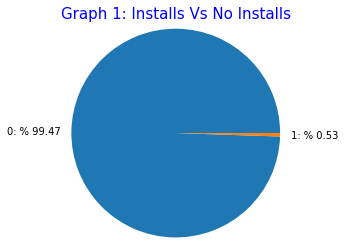

In [119]:
%matplotlib inline
plt.pie(installs,labels=labels,radius=1.2,shadow=False)
plt.title('Graph 1: Installs Vs No Installs',fontsize=15,color='b')


In [120]:
unique_vals = df.nunique().rename('Unique_Values',axis=1,inplace=True)
df_dtypes = df.dtypes.rename('Column Data Type',axis=1,inplace=True)
df_dtype_summary = pd.DataFrame(unique_vals).join(df_dtypes).sort_values(by='Unique_Values',ascending=False)

In [121]:
df.osv = df.osv.apply(osv_normalizer)
# normalizes the operation system Android version strings that might come in different writing versions
#for example: 8.1.0 is actually 8.1 , and 9.0 is actually 9, 8.1.1 stays 8.1

In [122]:
df.crid = df.crid.astype('O') #Creative ID should be considered a number

Text(0.5, 1.0, 'Graph 2: Population Distribution (%) as func of no. of unique ssps visited by user, \n')

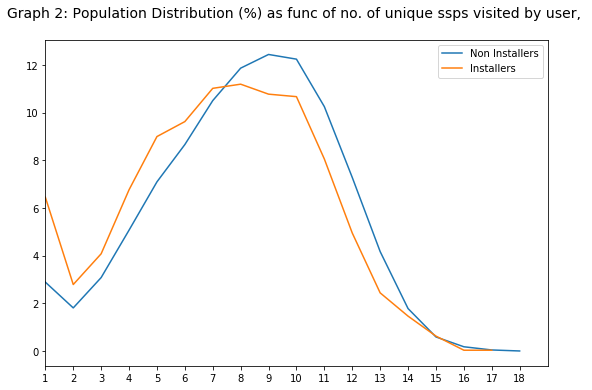

In [123]:
zeros = pd.DataFrame(100*df.ssps[df.install == 0].value_counts()/len(df[df.install == 0])).sort_index()
ones = 100*df.ssps[df.install == 1].value_counts()/len(df[df.install == 1])

zeros.join(ones,rsuffix='ones').plot(figsize=(9,6))
plt.legend(['Non Installers','Installers'])
plt.xlim(1,19)
plt.xticks(range(1,19))
plt.title('Graph 2: Population Distribution (%) as func of no. of unique ssps visited by user, \n',fontsize=14)

Text(0.5, 1.0, 'Graph 3: Log of No. Of Apps Per User , installers vs. non installers\n')

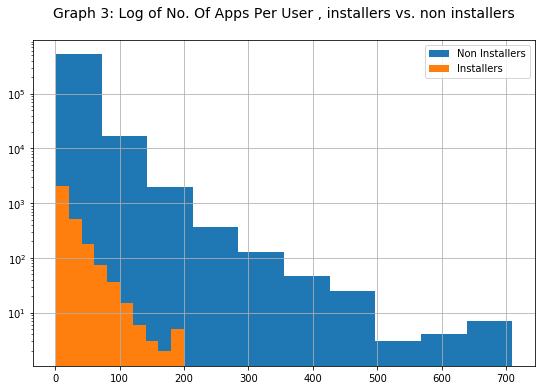

In [124]:
plt.figure(figsize=(9,6))
for key in installs.keys():
    df.apps[df.install == key].hist()
    
plt.legend(['Non Installers','Installers'])
plt.yscale('log')
plt.title('Graph 3: Log of No. Of Apps Per User , installers vs. non installers\n',fontsize=14)

Text(0.5, 1.0, 'Graph 4: Population Distribution (%) as func of no. of Pixels Per Inch (PPI) each by user, \n')

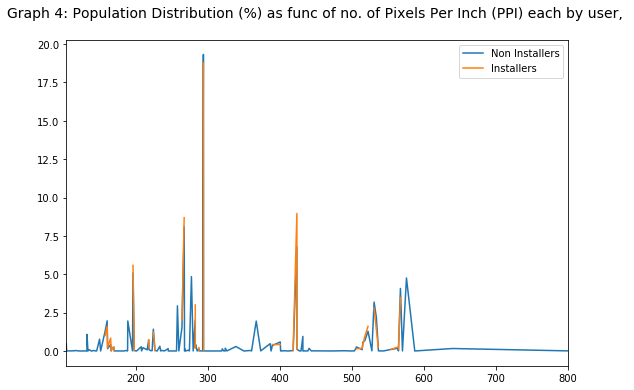

In [125]:
zeros = pd.DataFrame(100*df.ppi[df.install == 0].value_counts()/len(df[df.install == 0])).sort_index()
ones = 100*df.ppi[df.install == 1].value_counts()/len(df[df.install == 1])

zeros.join(ones,rsuffix='ones').plot(figsize=(9,6))
plt.legend(['Non Installers','Installers'])
plt.title('Graph 4: Population Distribution (%) as func of no. of Pixels Per Inch (PPI) each by user, \n',fontsize=14)


Text(0.5, 1.0, 'Graph 5: Population Distribution (%) as a func of Device Language \n')

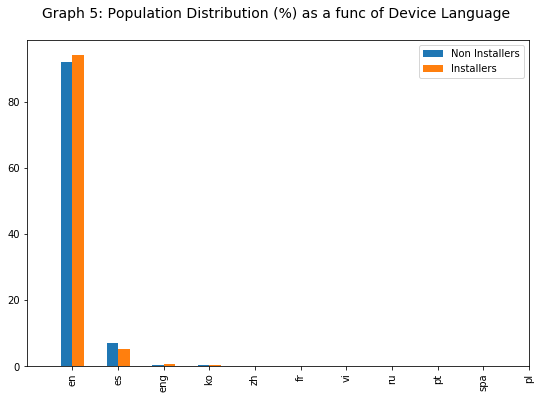

In [126]:
zeros = pd.DataFrame(100*df.devlang[df.install == 0].value_counts()/len(df[df.install == 0]))
ones = 100*df.devlang[df.install == 1].value_counts()/len(df[df.install == 1])

zeros.join(ones,rsuffix='ones').plot.bar(figsize=(9,6))
plt.legend(['Non Installers','Installers'])
plt.xlim(-1,10)
plt.title('Graph 5: Population Distribution (%) as a func of Device Language \n',fontsize=14)

In [127]:
dummies, target = col_Recommendation(df)      


Please consider engineering column: time
 It Has 544142 unique values
Please consider engineering column: deviceid
 It Has 227745 unique values


# Feature 'time' Engineering

In [128]:
df['local_time'] = df.time-df.utc_diff # convert from utc time and time differenct to local time
df.drop('utc_diff',axis=1,inplace=True) ## difference in hours from utc is irrelevant now

since we don't have information about more than 1 month, January,
variables such as day of month cannot be put against next month , 
So it's not a feature which is reasonable to use.
Hence we're going to engineer 'day of the week' and 'hour time frame' variables

In [129]:
df['local_time_bricks'] = convert_to_local_timeframe(df.local_time) # This Feature divides the day to 1hr bricks
df['weekday'] = df.local_time.apply(lambda x: x.isoweekday()) #day of the week, where Monday is 1 and Sunday is 7

24


# Feature 'deviceid' Engineering

#### We're aggregating data about device ids, according to the K-th time they were shown an ad during January,
#### And In case we see there's a point in engineering more features - we will

In [130]:
df['ad_no'] = df.sort_values(['deviceid','time']).groupby(['deviceid']).cumcount()+1 
# add a value of the k-th time the user was shown an ad at the time of January

Text(0.5, 1.0, 'Graph 6: Population Distribution (%) as a func of No. Of Times ad shown per user, \n')

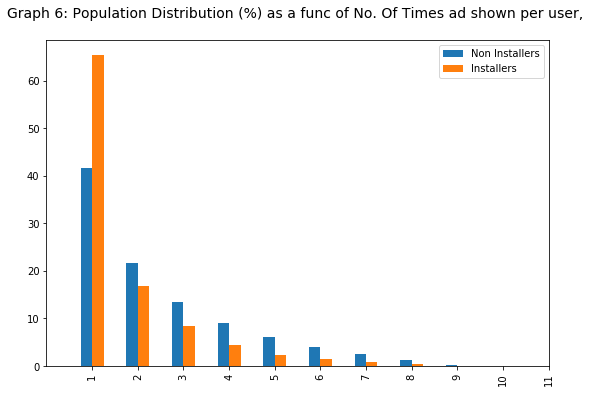

In [131]:
zeros = pd.DataFrame(100*df.ad_no[df.install == 0].value_counts()/len(df[df.install == 0]))
ones = 100*df.ad_no[df.install == 1].value_counts()/len(df[df.install == 1])

zeros.join(ones,rsuffix='ones').plot.bar(figsize=(9,6))
plt.legend(['Non Installers','Installers'])
plt.xlim(-1,10)
plt.title('Graph 6: Population Distribution (%) as a func of No. Of Times ad shown per user, \n',fontsize=14)

### Columns - Report
Dropping above 10K unique values in the prediction after engineering 

In [132]:
dummies_columns, target_columns = col_Recommendation(df,return_cols=1)
print("Columns For Dummy Encoding:\n{}\n \nColumns For Target Encoding:\n{} ".format(dummies_columns,target_columns))

Please consider engineering column: time
 It Has 544142 unique values
Please consider engineering column: deviceid
 It Has 227745 unique values
Please consider engineering column: local_time
 It Has 508337 unique values
Columns For Dummy Encoding:
['sspid', 'contype', 'netspeed', 'uadevicetype', 'agebucket', 'gender', 'bundletotalfc', 'Video Name', 'weekday']
 
Columns For Target Encoding:
['crid', 'devlang', 'bundle', 'make', 'model', 'osv', 'isp', 'state', 'uabatterycapacity', 'uadeviceram', 'uareleaseyear', 'uamaxinternalstorage', 'uascreenpixelswidth', 'uascreenpixelsheight', 'uascreeninchesdiagonal', 'ppi', 'ssps', 'apps', 'bundleAvgUserRating', 'bundleCategory', 'local_time_bricks', 'ad_no'] 


In [133]:
df = df.drop(['time','deviceid','local_time'],axis=1) # after engineering data from the uppermentioned columns we can from the values.

# Data Encoding and handling missing in categories

## The vast majority of the data is either categorical or ordinal (no. of times a user watched an ad is a good example - first time , second, etc..)

## Only float - continouos variable is ppi which is pixels per inch for  the users' screen, hence again a variable of the device which we can see in Graph 4, has pattern what so over 

## Hence, we assume all of our data is categorcal / Ordinal and should be treated with feature_na in case of nan value.

# ua features - refers to User Agent, and this is a string that is being parsed that describes the data aboutThe device information, such as ram memory, storage,width and height of the screen, battery capacity etc.
# agebucket, gender features -  are details which the user chooses to reveal while using an app, and we can see that       most users choose not to disclose their gender/age while using commercialized apps
# bundlecategory - is an enrichement of data, that uses the bundle, to disclose all the categories in which it 


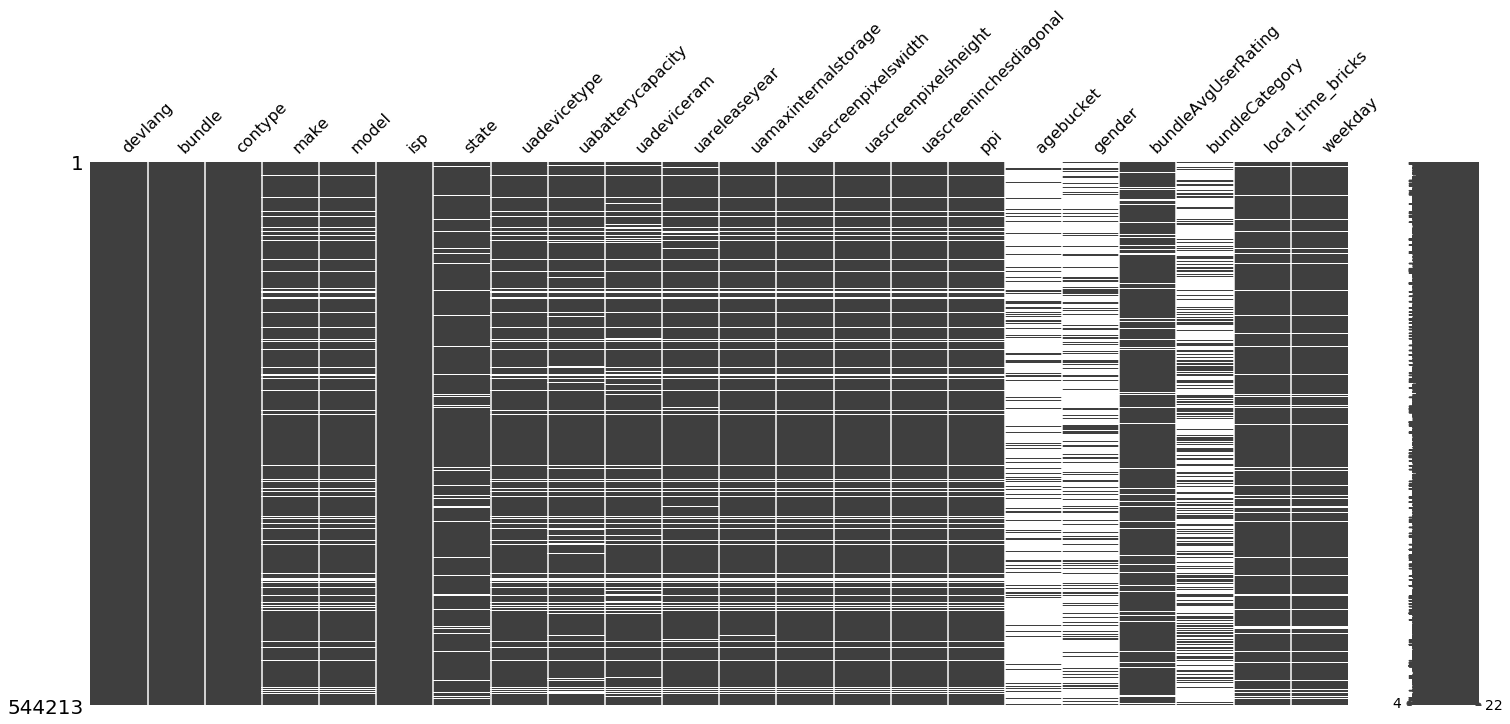

In [134]:
missingdata_df = df.columns[df.isnull().any()].tolist()
msno.matrix(df[missingdata_df])
print('# ua features - refers to User Agent, and this is a string that is being parsed that describes the data about\
The device information, such as ram memory, storage,width and height of the screen, battery capacity etc.')

print('# agebucket, gender features -  are details which the user chooses to reveal while using an app, and we can see that\
       most users choose not to disclose their gender/age while using commercialized apps')

print('# bundlecategory - is an enrichement of data, that uses the bundle, to disclose all the categories in which it ')


# Outliers Handling

In [135]:
outlier_report = pd.DataFrame(columns=['Col_Name','OutlierCount'])

for col in df.columns:
    if (df[col].nunique() > 2) & (df[col].dtype != 'O'):
        zscore_mask =  zscore_outliers(df,col, cutoff=3.0, return_thresholds=False)
        outlier_len = len(df[col][zscore_mask])
        if (outlier_len == 0):
            continue   
        outlier_report = outlier_report.append({'Col_Name':col, 'OutlierCount' : outlier_len} , ignore_index=True)
        
outlier_report

,Col_Name,OutlierCount
0,uabatterycapacity,18474
1,uadeviceram,789
2,uareleaseyear,478
3,uamaxinternalstorage,17965
4,uascreenpixelswidth,1046
5,uascreenpixelsheight,33
6,uascreeninchesdiagonal,4255
7,ppi,33
8,ssps,17
9,apps,10539


In [136]:
outliers_df = df.copy()

### Device Release Year

In [137]:
len(outliers_df[outliers_df.uareleaseyear< 2014])

478

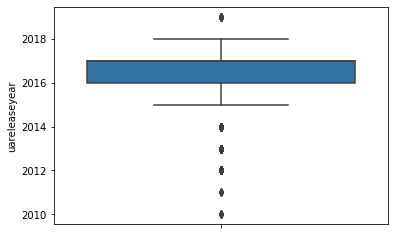

In [138]:
sns.boxplot(y=df.uareleaseyear)

In [139]:
#removing all records with years below 2014
print("before removing release year outlier: ",len(outliers_df))
outliers_df = outliers_df[~(outliers_df.uareleaseyear < 2014)]
print("after removing release year outlier: ",len(outliers_df))

before removing release year outlier:  544213
after removing release year outlier:  543735


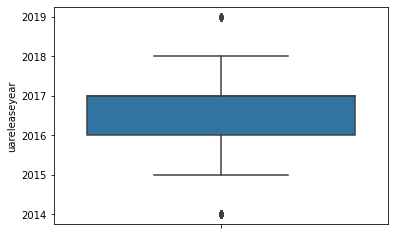

In [140]:
sns.boxplot(y=outliers_df.uareleaseyear)

### Apps

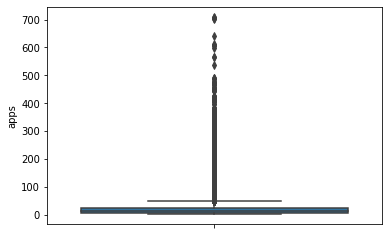

In [141]:
sns.boxplot(y=outliers_df.apps)

In [142]:
df[df.apps>90].apps.value_counts().sum()

10539

In [143]:
#removing all records with years below 2014
print("before removing apps outlier: ",len(outliers_df))
outliers_df = outliers_df[~(outliers_df.apps > 90)]
print("after removing apps outlier: ",len(outliers_df))

before removing apps outlier:  543735
after removing apps outlier:  533199


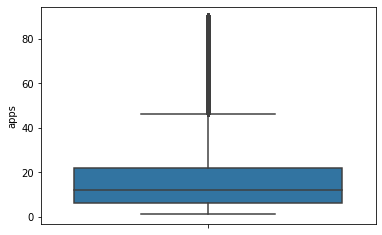

In [144]:
sns.boxplot(y=outliers_df.apps)

### Device Battery capacity

### check device types

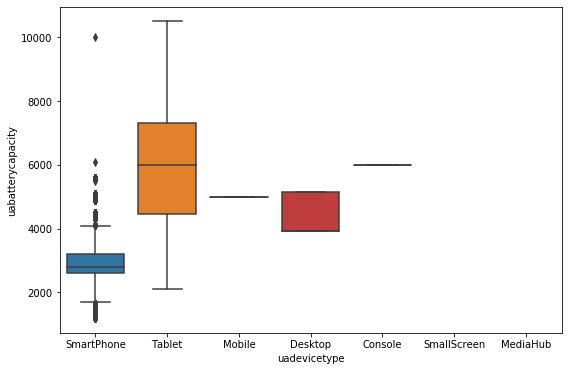

In [145]:
plt.figure(figsize=(9,6))
sns.boxplot(y=outliers_df.uabatterycapacity,x=outliers_df.uadevicetype)



In [146]:
outliers_df.uadevicetype.value_counts(dropna=False)

SmartPhone     398105
NaN             67754
Tablet          66441
Desktop           532
Mobile            299
SmallScreen        44
Console            13
MediaHub           11
Name: uadevicetype, dtype: int64

In [147]:
# We see that Tablets are have better battery capacity, so this is not an outlier.
# However Since the Campaign is targetted at mobiles and Tablets, all the rest of the devicetypes are clearly outliers.

In [148]:
#removing all records with devicetypes which shouldn't be there
print("before removing devices outlier: ",len(outliers_df))
outliers_df = outliers_df[(outliers_df.uadevicetype.isin(['Tablet','SmartPhone',np.nan]))]
print("after removing devices outlier: ",len(outliers_df))


before removing devices outlier:  533199
after removing devices outlier:  532300


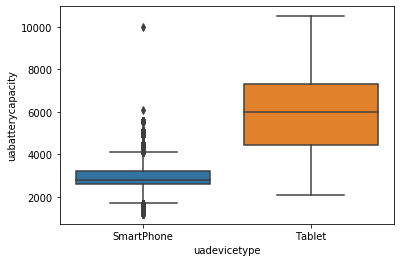

In [149]:
sns.boxplot(y=outliers_df.uabatterycapacity,x=outliers_df.uadevicetype)

In [150]:
bat_filt = outliers_df.uadevicetype == 'SmartPhone'
mem_filt = ~outliers_df.uabatterycapacity.between(1600,4800)
null_fil = ~outliers_df.uabatterycapacity.isnull()

In [151]:
print("before removing battery outlier: ",len(outliers_df))
outliers_df = outliers_df[~(mem_filt & null_fil & bat_filt)] ## removing all not null, smartphones with out of bounds batteries
print("after removing battery outlier: ",len(outliers_df))

before removing battery outlier:  532300
after removing battery outlier:  527701


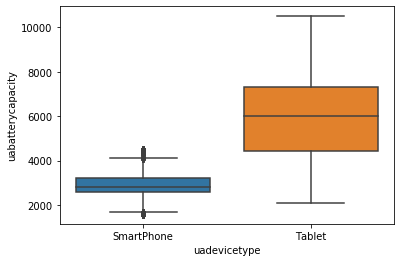

In [152]:
sns.boxplot(y=outliers_df.uabatterycapacity,x=outliers_df.uadevicetype)

In [153]:
print("before removing battery outlier: ",len(outliers_df))
outliers_df.loc[bat_filt] = outliers_df.loc[bat_filt & ~outliers_df.uabatterycapacity.between(1600,4800)] 
print("after removing battery outlier: ",len(outliers_df))

before removing battery outlier:  527701
after removing battery outlier:  527701


### Ad number 

8.0


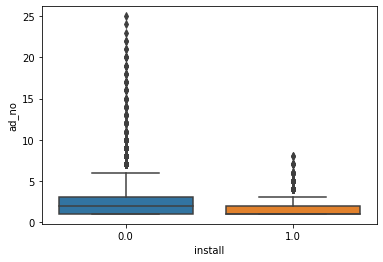

In [154]:
sns.boxplot(y=outliers_df.ad_no,x=outliers_df.install)
print(max(outliers_df.ad_no[outliers_df.install == 1]))

In [155]:
print("before removing ads shown more than 10 times outlier: ",len(outliers_df))
outliers_df = outliers_df.loc[outliers_df.ad_no <= 10] 
print("after removing ads shown more than 10 times outlier: ",len(outliers_df))

before removing ads shown more than 10 times outlier:  527701
after removing ads shown more than 10 times outlier:  141762


8.0


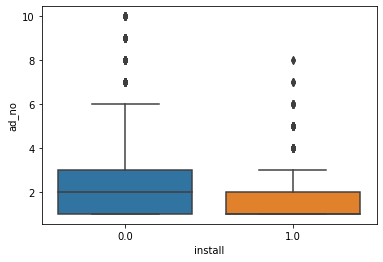

In [156]:
sns.boxplot(y=outliers_df.ad_no,x=outliers_df.install)
print(max(outliers_df.ad_no[outliers_df.install == 1]))

### SSPS

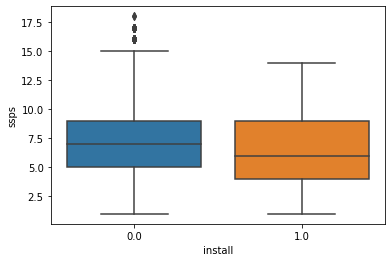

In [157]:
sns.boxplot(y=outliers_df.ssps,x=outliers_df.install)


### Bundle Rating

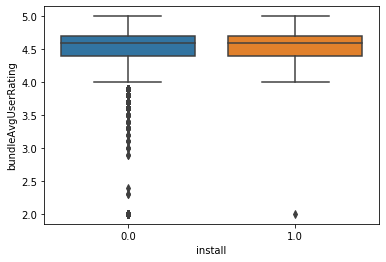

In [158]:
sns.boxplot(y=outliers_df.bundleAvgUserRating,x=outliers_df.install)

In [159]:
rating = ~outliers_df.bundleAvgUserRating.between(0,3.5)

print("before removing ads shown in 0-3.5 rated apps: ",len(outliers_df))
outliers_df = outliers_df.loc[rating] 
print("after removing ads shown in 0-3.5 rated apps: ",len(outliers_df))

before removing ads shown in 0-3.5 rated apps:  141762
after removing ads shown in 0-3.5 rated apps:  141477


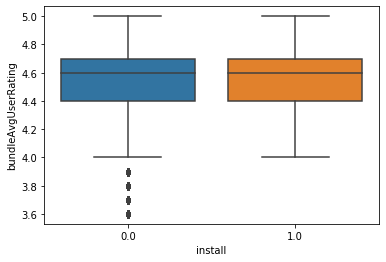

In [160]:
sns.boxplot(y=outliers_df.bundleAvgUserRating,x=outliers_df.install)

## RAM

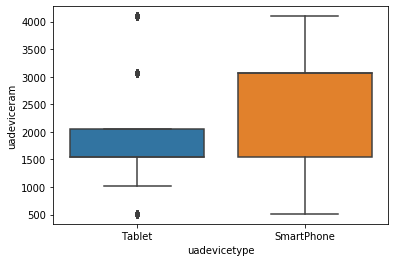

In [161]:
sns.boxplot(y=outliers_df.uadeviceram,x=outliers_df.uadevicetype)

In [162]:
tab_filt = outliers_df.uadevicetype == 'Tablet'
ram = outliers_df.uadeviceram < 1000

In [163]:
print("before removing ads shown in low ram memory tablets:: ",len(outliers_df))
outliers_df = outliers_df[~(tab_filt & ram )]
print("after removing ads shown in low ram memory tablets: ",len(outliers_df))

before removing ads shown in low ram memory tablets::  141477
after removing ads shown in low ram memory tablets:  141448


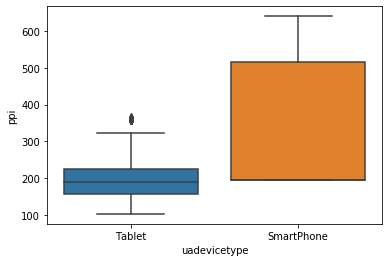

In [164]:
sns.boxplot(y=outliers_df.ppi,x=outliers_df.uadevicetype)

In [165]:
outliers_df.model[outliers_df.ppi>700].unique()

array([], dtype=object)

In [166]:
#These are Sony Xperia Models, there's nothing to imply on user behavior here

# Encoding Data

## Since most of the data doesn't contain Continuous values, and the one which does  - PPI, There's no continouos data that we can impute in, and all is categorical data - we can apply  "Feature_NA" on our categorical Data when Encoding Data. 

In [167]:
# applying target encoding for columns recommended for mean ecoding
outliers_df = target_encoder(outliers_df,target_columns)

In [168]:
# applying one-hot_encoding for dummy columns
outliers_df = pd.get_dummies(outliers_df,columns=dummies_columns,dummy_na=True)

In [169]:
outliers_df.shape


(141448, 78)

# Feature selection

In [170]:
outliers_df.crid_mean = outliers_df.crid_mean.astype(float)

In [171]:
X = outliers_df.drop('install',axis=1)
y = outliers_df.install

coaf_df, light_cls, cat_cls, rf_cls = feature_importance_table(X, y, 2);

running CatBoost
running RF
running LIGHTGBM


In [172]:
coaf_df.sort_values(by=['LIGHTGBM','CatBoost','RND_FOREST'],ascending=False)
scaler = MinMaxScaler()

coaf_df[coaf_df.columns] = scaler.fit_transform(coaf_df[coaf_df.columns])
coaf_df['Avg_Score'] = coaf_df.mean(axis=1)

In [173]:
feature_list = coaf_df.sort_values(by='Avg_Score',ascending=False).head(25).index.tolist()

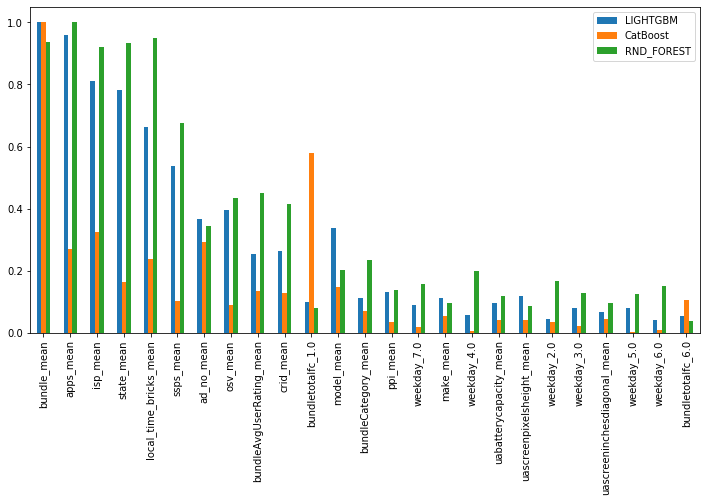

In [174]:
coaf_df.ix[feature_list].iloc[:,:3].plot.bar(figsize=(12,6))

###  Model Training

In [175]:
X_train, X_test, y_train, y_test = train_test_split(X[feature_list], y,stratify=y,test_size=0.20)
X_train, X_dev, y_train, y_dev = train_test_split(X_train, y_train,stratify=y_train,test_size=0.20)

In [176]:
ros_under = RandomUnderSampler()
ros_over = RandomOverSampler()
ros_smoth = SMOTE()

In [177]:
# ros_under.fit(X_train, y_train)
X_resampled_rus, y_resampled_rus = ros_under.fit_sample(X_train, y_train)
X_resampled_ros, y_resampled_ros = ros_over.fit_sample(X_train, y_train)
X_resampled_smo, y_resampled_smo = ros_smoth.fit_sample(X_train, y_train)
#adding the feature list
X_resampled_rus = pd.DataFrame(X_resampled_rus,columns=feature_list)
X_resampled_ros = pd.DataFrame(X_resampled_ros,columns=feature_list)
X_resampled_smo = pd.DataFrame(X_resampled_smo,columns=feature_list)

In [178]:
print(len(X_resampled_rus))
print(len(X_resampled_ros))
print(len(X_resampled_smo))

1020
180032
180032


### Cat Boost

In [179]:
Sampled = ["NoneSampled","UnderSampled","OverSampled","Smoth"]
Models = ["CATBoost","Light","RF"]

all_models = {}

In [180]:
import tqdm 

In [181]:
classifiers = [CatBoostClassifier(verbose=False,iterations=100,learning_rate=0.05), LGBMClassifier(), RandomForestClassifier()]
Datas = [(X_train,y_train),(X_resampled_rus,y_resampled_rus),(X_resampled_ros,y_resampled_ros),(X_resampled_smo,y_resampled_smo)]

for i in range(3):
    all_models[Models[i]] = {}
    for j in tqdm.tqdm(range(4)):
        all_models[Models[i]][Sampled[j]] = {} 
        all_models[Models[i]][Sampled[j]]["Classifier"] = classifiers[i]
        all_models[Models[i]][Sampled[j]]["Model"] = all_models[Models[i]][Sampled[j]]["Classifier"]\
            .fit(X = Datas[j][0], y = Datas[j][1])
        all_models[Models[i]][Sampled[j]]["Prediction"] = all_models[Models[i]][Sampled[j]]["Model"].predict(X_dev)
            

100%|████████████████████████████████████████████| 4/4 [00:12<00:00,  3.18s/it]


In [182]:
Model_Comparison = pd.DataFrame(columns = Sampled,index=Models)

for model in Models: 
    for sample in Sampled:
        fpr, tpr, thrasholds = roc_curve(y_dev, all_models[model][sample]["Prediction"], pos_label=1)
        roc_auc = auc(fpr, tpr)
        Model_Comparison.loc[model,sample] = roc_auc
        
        
print("Winning Model and Sampling Method with best auc:\n{}".format(Model_Comparison.stack().sort_values(ascending=False).head(1)))

Winning Model and Sampling Method with best auc:
CATBoost  UnderSampled   0.7371
dtype: object


In [183]:
folds = 20
param_comb = 20
skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)

cat = CatBoostClassifier()
params = {
                  'depth':[3,1,2,6,4,5,7],
                  'iterations':[128,256,512,64],
                  'learning_rate':[0.03,0.01,0.1,0.2,0.3], 
                  'l2_leaf_reg':[3,1,5,10,30],
                  'border_count':[32,5,10,20,64,128],
                  
                  

         }

random_search = RandomizedSearchCV(cat, param_distributions=params, n_iter=param_comb, n_jobs=-1, cv=skf.split(X_resampled_rus,y_resampled_rus),scoring='accuracy', verbose=3, random_state=1001 )

In [184]:
random_search.fit(X_resampled_rus,y_resampled_rus)

Fitting 20 folds for each of 20 candidates, totalling 400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed: 16.5min
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed: 22.9min finished


0:	learn: 0.6701201	total: 20.8ms	remaining: 10.6s
1:	learn: 0.6567100	total: 37.9ms	remaining: 9.66s
2:	learn: 0.6426071	total: 56.8ms	remaining: 9.64s
3:	learn: 0.6290664	total: 77.9ms	remaining: 9.89s
4:	learn: 0.6248177	total: 98.2ms	remaining: 9.96s
5:	learn: 0.6162406	total: 114ms	remaining: 9.64s
6:	learn: 0.6141125	total: 137ms	remaining: 9.86s
7:	learn: 0.6023625	total: 153ms	remaining: 9.67s
8:	learn: 0.5963032	total: 174ms	remaining: 9.72s
9:	learn: 0.5857979	total: 195ms	remaining: 9.8s
10:	learn: 0.5806370	total: 211ms	remaining: 9.59s
11:	learn: 0.5756552	total: 229ms	remaining: 9.52s
12:	learn: 0.5733215	total: 247ms	remaining: 9.48s
13:	learn: 0.5683827	total: 283ms	remaining: 10.1s
14:	learn: 0.5559912	total: 303ms	remaining: 10s
15:	learn: 0.5518977	total: 320ms	remaining: 9.91s
16:	learn: 0.5507847	total: 340ms	remaining: 9.89s
17:	learn: 0.5482347	total: 365ms	remaining: 10s
18:	learn: 0.5443907	total: 380ms	remaining: 9.87s
19:	learn: 0.5418544	total: 405ms	remaini

161:	learn: 0.4463023	total: 3.19s	remaining: 6.9s
162:	learn: 0.4462988	total: 3.21s	remaining: 6.87s
163:	learn: 0.4462725	total: 3.23s	remaining: 6.84s
164:	learn: 0.4462657	total: 3.25s	remaining: 6.82s
165:	learn: 0.4462625	total: 3.26s	remaining: 6.8s
166:	learn: 0.4461742	total: 3.28s	remaining: 6.77s
167:	learn: 0.4458621	total: 3.29s	remaining: 6.75s
168:	learn: 0.4457718	total: 3.31s	remaining: 6.72s
169:	learn: 0.4457715	total: 3.33s	remaining: 6.7s
170:	learn: 0.4456723	total: 3.35s	remaining: 6.68s
171:	learn: 0.4456153	total: 3.37s	remaining: 6.65s
172:	learn: 0.4452943	total: 3.39s	remaining: 6.65s
173:	learn: 0.4452895	total: 3.41s	remaining: 6.63s
174:	learn: 0.4452570	total: 3.43s	remaining: 6.6s
175:	learn: 0.4451247	total: 3.45s	remaining: 6.58s
176:	learn: 0.4449505	total: 3.47s	remaining: 6.56s
177:	learn: 0.4448747	total: 3.48s	remaining: 6.53s
178:	learn: 0.4448181	total: 3.5s	remaining: 6.51s
179:	learn: 0.4447564	total: 3.52s	remaining: 6.49s
180:	learn: 0.444

320:	learn: 0.4304641	total: 6.23s	remaining: 3.7s
321:	learn: 0.4304432	total: 6.24s	remaining: 3.68s
322:	learn: 0.4303664	total: 6.26s	remaining: 3.66s
323:	learn: 0.4302963	total: 6.28s	remaining: 3.65s
324:	learn: 0.4302600	total: 6.3s	remaining: 3.62s
325:	learn: 0.4302380	total: 6.32s	remaining: 3.6s
326:	learn: 0.4301719	total: 6.33s	remaining: 3.58s
327:	learn: 0.4301534	total: 6.35s	remaining: 3.56s
328:	learn: 0.4301375	total: 6.37s	remaining: 3.54s
329:	learn: 0.4301360	total: 6.39s	remaining: 3.52s
330:	learn: 0.4301057	total: 6.41s	remaining: 3.5s
331:	learn: 0.4300021	total: 6.43s	remaining: 3.49s
332:	learn: 0.4298824	total: 6.45s	remaining: 3.47s
333:	learn: 0.4298130	total: 6.47s	remaining: 3.45s
334:	learn: 0.4297630	total: 6.48s	remaining: 3.42s
335:	learn: 0.4297239	total: 6.5s	remaining: 3.41s
336:	learn: 0.4297099	total: 6.52s	remaining: 3.38s
337:	learn: 0.4295761	total: 6.54s	remaining: 3.36s
338:	learn: 0.4295605	total: 6.55s	remaining: 3.35s
339:	learn: 0.429

479:	learn: 0.4221469	total: 9.17s	remaining: 612ms
480:	learn: 0.4221469	total: 9.19s	remaining: 592ms
481:	learn: 0.4221401	total: 9.22s	remaining: 574ms
482:	learn: 0.4221274	total: 9.24s	remaining: 555ms
483:	learn: 0.4221273	total: 9.26s	remaining: 536ms
484:	learn: 0.4221176	total: 9.28s	remaining: 516ms
485:	learn: 0.4220867	total: 9.3s	remaining: 497ms
486:	learn: 0.4219264	total: 9.31s	remaining: 478ms
487:	learn: 0.4219257	total: 9.33s	remaining: 459ms
488:	learn: 0.4219022	total: 9.35s	remaining: 440ms
489:	learn: 0.4218696	total: 9.37s	remaining: 421ms
490:	learn: 0.4218679	total: 9.38s	remaining: 401ms
491:	learn: 0.4218234	total: 9.4s	remaining: 382ms
492:	learn: 0.4217713	total: 9.41s	remaining: 363ms
493:	learn: 0.4217699	total: 9.44s	remaining: 344ms
494:	learn: 0.4217614	total: 9.46s	remaining: 325ms
495:	learn: 0.4217405	total: 9.47s	remaining: 306ms
496:	learn: 0.4217217	total: 9.49s	remaining: 286ms
497:	learn: 0.4217005	total: 9.51s	remaining: 267ms
498:	learn: 0.

RandomizedSearchCV(cv=<generator object _BaseKFold.split at 0x0000027E0FA5CA98>,
                   error_score='raise-deprecating',
                   estimator=<catboost.core.CatBoostClassifier object at 0x0000027E15DFA978>,
                   iid='warn', n_iter=20, n_jobs=-1,
                   param_distributions={'border_count': [32, 5, 10, 20, 64,
                                                         128],
                                        'depth': [3, 1, 2, 6, 4, 5, 7],
                                        'iterations': [128, 256, 512, 64],
                                        'l2_leaf_reg': [3, 1, 5, 10, 30],
                                        'learning_rate': [0.03, 0.01, 0.1, 0.2,
                                                          0.3]},
                   pre_dispatch='2*n_jobs', random_state=1001, refit=True,
                   return_train_score=False, scoring='accuracy', verbose=3)

In [185]:
random_search.best_params_

{'border_count': 64,
 'depth': 1,
 'iterations': 512,
 'l2_leaf_reg': 3,
 'learning_rate': 0.2}

In [186]:
cat = CatBoostClassifier(**random_search.best_params_,verbose=False)

In [187]:
final_model = cat.fit(X=X_resampled_rus, y=y_resampled_rus)

In [188]:
final_pred = final_model.predict(X_test).astype(pd.Series)#.rename("pred_install",axis=1)
fpr, tpr, thrasholds = roc_curve(y_test, final_pred, pos_label=1)
roc_auc = auc(fpr, tpr)
print(roc_auc)

0.7350710255187489


In [189]:
pd.crosstab(y_test,final_pred)

col_0,0.0,1.0
install,,
0.0000,19241,8890
1.0000,34,125


Text(0.5, 0, 'False Positive Rate')

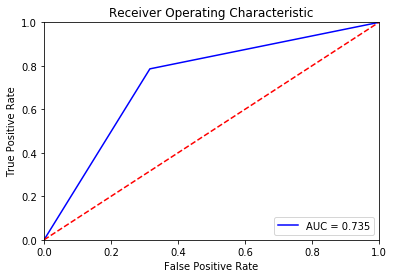

In [190]:
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.3f' % roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.legend(loc = 'lower right')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')